In [1]:
# python setup.py bdist_wheel
# pip install -e .


from evolution import genetic_algorithm as ga
import numpy as np
import string
from copy import copy

In [81]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from collections import OrderedDict
import time

class Cache(object):
    def __init__(self,size):
        self.storage = OrderedDict()
        self.limit = size

    def add(self,key,value):
        
        current_time = time.time()

        self.storage[key] = {
            "value" : value,
            "timestamp": current_time
        }

        self.storage.move_to_end(key)
        self._enforce_size_constraint()

    def get(self,key):
        current_time = time.time()

        if key not in self.storage:
            return None
        
        self.storage[key]['timestamp'] = current_time

        item = self.storage[key]

        self.storage.move_to_end(key)

        return item["value"]
    

    def _enforce_size_constraint(self):
        """Evict the oldest accessed item if the cache exceeds the max size."""
        if len(self.storage) > self.limit:
            # Remove the first item (oldest accessed item)
            self.storage.popitem(last=False)

    def __repr__(self):
        """Display the current cache contents."""
        return str({
            key: {
                "value": meta["value"],
                "timestamp": meta["timestamp"]
            }
            for key, meta in self.storage.items()
        })

cache = Cache(size=1000)
fitness_calls = 0
total_fitness_calls = 0

def _metric(candidate):
    return 0.1

def _repr(candidae):
    return f"Nothing to Show"

class Ind(object):
    def __init__(self,copy=False,**kwargs):

        self.kwargs          = kwargs
        self._gene           = None
        self._fitness        = None  

        self.metric          = kwargs.get('metric') if kwargs.get('metric') else _metric
        self.repr            = kwargs.get('repr')   if kwargs.get('repr')   else _repr

        if not copy:
            self.generate()

    def generate(self):
        kwargs = self.kwargs
        gene_type           = kwargs.get('gene_type')        if kwargs.get('gene_type')        else 'integer'
        gene_size           = kwargs.get('gene_size')        if kwargs.get('gene_size')        else 10
        gene_upper_limit    = kwargs.get('gene_upper_limit') if kwargs.get('gene_upper_limit') else 10
        init_method         = kwargs.get('init_method')      if kwargs.get('init_method')      else "random" 

        if init_method == 'mix':
            init_method = "random" if np.random.rand()<0.5 else "zeros"

        if init_method == "random":
            if gene_type == 'binary':
                self._gene = np.random.randint(2, size=gene_size)

            elif gene_type == 'integer':
                self._gene = np.random.randint(gene_upper_limit, size=gene_size)

            elif gene_type == 'real':
                self._gene = np.random.rand(gene_size)*gene_upper_limit

            else:
                raise(f"{gene_type} is not a Valid Gene Type")
        elif init_method == "zeros":
            self._gene = np.zeros(gene_size)
        else: 
            raise(f"{init_method} is not a Initialization Method")
        
    @property
    def fitness(self):
        if self._fitness == None:
            global total_fitness_calls
            total_fitness_calls+=1
            cached_fitness = cache.get(str(self._gene))
            if cached_fitness:
                self._fitness = cached_fitness
            else:
                global fitness_calls
                fitness_calls+=1
                self._fitness = self.metric(self._gene)
                cache.add(str(self._gene),self._fitness)
            
        return self._fitness

    @property
    def gene(self):
        if self._gene:
            return self._gene
        else:
            return "No genome Available"
    
    def mutate(self,prob = 1.0):

        if np.random.rand() < prob:
            kwargs = self.kwargs
            mutation_type       = kwargs.get('mutation_type')    if kwargs.get('mutation_type')    else 'random range'
            gene_type           = kwargs.get('gene_type')        if kwargs.get('gene_type')        else 'integer'
            gene_upper_limit    = kwargs.get('gene_upper_limit') if kwargs.get('gene_upper_limit') else 10
            mutation_range      = kwargs.get('mutation_range')   if kwargs.get('mutation_range')   else (-1,1) 

            if mutation_type == 'random range':

                low,high = mutation_range
                i = np.random.randint(len(self._gene))

                if gene_type == 'real':
                    self._gene[i] += np.random.rand()*(high - low) + low

                else:
                    self._gene[i] += np.random.randint(low = low,high = high+1)
                    self._gene[i] %= (gene_upper_limit+1)
            else:
                raise(f"{mutation_type} is not a Valid Mutation Type")
            
            self._fitness = None
        
        return self
    
    def copy(self):
        c = Ind(copy=True,**self.kwargs)
        c._gene           = self._gene
        c._fitness        = self._fitness  

        return c


    def crossover(self,dad):
        kwargs = self.kwargs
        crossover_type  = kwargs.get('crossover_type')      if kwargs.get('crossover_type')  else 'split'
        cromossome_size = kwargs.get('cromossome_size')     if kwargs.get('cromossome_size') else 1

        n_cromossomes = len(self._gene)//cromossome_size

        new_gene = []
        if crossover_type == "random mix":
            choice = np.random.randint(2, size=n_cromossomes)
            
            for i,c in enumerate(choice):
                if c:
                    new_gene.extend(self._gene[i*cromossome_size:(i+1)*cromossome_size])
                else:
                    new_gene.extend(self._gene[i*cromossome_size:(i+1)*cromossome_size])
        elif crossover_type == "split":

            split_size = np.random.rand()

            cut_point = int(len(self._gene)*split_size)

            new_gene.extend(dad._gene[:cut_point])
            new_gene.extend(self._gene[cut_point:])


        else:
            raise(f"{crossover_type} is not a Valid Crossover Type")

        


        child = Ind(**self.kwargs)
        child._gene = new_gene

        return child

    def __repr__(self):
        return self.repr(self._gene)
    

def _roulette(fitness_list,pop,n):

    if n <= 0:
        return []

    fitness_list = np.array(fitness_list,dtype=float)

    info = 1/fitness_list

    prob = np.array(info)/np.sum(info)
    sur = np.random.choice(pop, size=n, p=prob, replace=False).tolist()

    return [s.copy() for s in sur]


def run(max_gen=100,pop_size=30,prole_size=10,mutation_rate=1/30,stop=0.5,verbose=True,**kwargs):

    cache_size = kwargs.get("cache_size") if kwargs.get("cache_size") else 1000


    global fitness_calls
    global total_fitness_calls
    fitness_list_best = []
    fitness_list_avg  = []
    fitness_calls = 0
    total_fitness_calls = 0
    pop = []

    pbar = tqdm(list(range(pop_size)))

    for i in pbar:
        pop.append(Ind(**kwargs))
        pbar.set_description(f"Loading Initial Population | Current Fitness = {pop[i].fitness:.2e}")


    pop.sort(key = lambda x: x.fitness)
    best_global = pop[0].copy()
    pbar = tqdm(list(range(max_gen)))

    for gen in pbar:
    
        fitness_list = [ind.fitness for ind in pop]
        if best_global.fitness > pop[0].fitness:
            best_global = pop[0].copy() 
            if best_global.fitness <= stop:
                break
        
        best = best_global.fitness
        avg  = np.mean(fitness_list)

        fitness_list_avg.append(avg)
        fitness_list_best.append(best)
                
        pbar.set_description(f"AVG = {avg:.2e} | BEST = {best:.2e} | {best_global} |Total Calls {fitness_calls:5d} | {total_fitness_calls-fitness_calls:5d}")

        survivors = _roulette(fitness_list.copy(), pop.copy(), pop_size - prole_size)

        new_gen = [s.mutate(mutation_rate) for s in survivors]

        for _ in range(prole_size):
            parents = _roulette(fitness_list, pop, 2)
            mum = parents[0]
            dad = parents[1]
            kid = mum.crossover(dad).mutate(mutation_rate)
            new_gen.append(kid)

        new_gen.sort(key=lambda x: x.fitness)
        pop = new_gen[:pop_size]


    if verbose:
        plt.figure(figsize=(20, 6))
        plt.suptitle("Genetic Algorithm Evolution Graph", fontsize=25)

        plt.plot(fitness_list_best,'--',color="lightsteelblue",label="Best")
        plt.plot(fitness_list_avg,'--',color="lightcoral",label="Average")

        plt.xlabel("generation")
        plt.ylabel("Fitness")

        plt.legend()
        plt.show()

    return best_global

## Exemplo combinacional com gene Inteiro 

Loading Initial Population | Current Fitness = 2067.00:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Initial Population | Current Fitness = 2155.00: 100%|██████████| 1000/1000 [00:01<00:00, 930.48it/s]
AVG = 1.90e+03 | BEST = 1.14e+03 | &Æ T8vXÛ!µ)*1j´¯x[\ |Total Calls  3523 |    63:   0%|          | 9/10000 [00:03<1:08:17,  2.44it/s]
AVG = 1.90e+03 | BEST = 1.14e+03 | &Æ T8vXÛ!µ)*1j´¯x000 [00:03<1:08:17,  2.44it/s]
AVG = 1.87e+03 | BEST = 1.06e+03 | &Æ T8vXÛ!µ)*1j´¯x0000 [00:04<1:08:41,  2.42it/s]
AVG = 1.87e+03 | BEST = 1.06e+03 | &Æ T8vXÛ!µ)*1j´¯x0000 [00:04<1:08:41,  2.42it/s]
AVG = 1.85e+03 | BEST = 1.06e+03 | &Æ T8vXÛ!µ)*1j´¯x0000 [00:04<1:07:47,  2.46it/s]
AVG = 1.85e+03 | BEST = 1.06e+03 | &Æ T8vXÛ!µ)*1j´¯x0000 [00:04<1:07:47,  2.46it/s]
AVG = 1.82e+03 | BEST = 1.06e+03 | &Æ T8vXÛ!µ)*1j´¯x0000 [00:04<1:08:17,  2.44it/s]
AVG = 1.82e+03 | BEST = 1.06e+03 | &Æ T8vXÛ!µ)*1j´¯x0000 [00:04<1:08:17,  2.44it/s]
AVG = 1.80e+03 | BEST = 1.06e+03 | &Æ T8vXÛ!µ)*1j´¯x0000 [00:05<1:08:35,  2.43it/s]
AVG = 1.80e+03 | BEST = 1.06e+03 | &Æ T8vXÛ

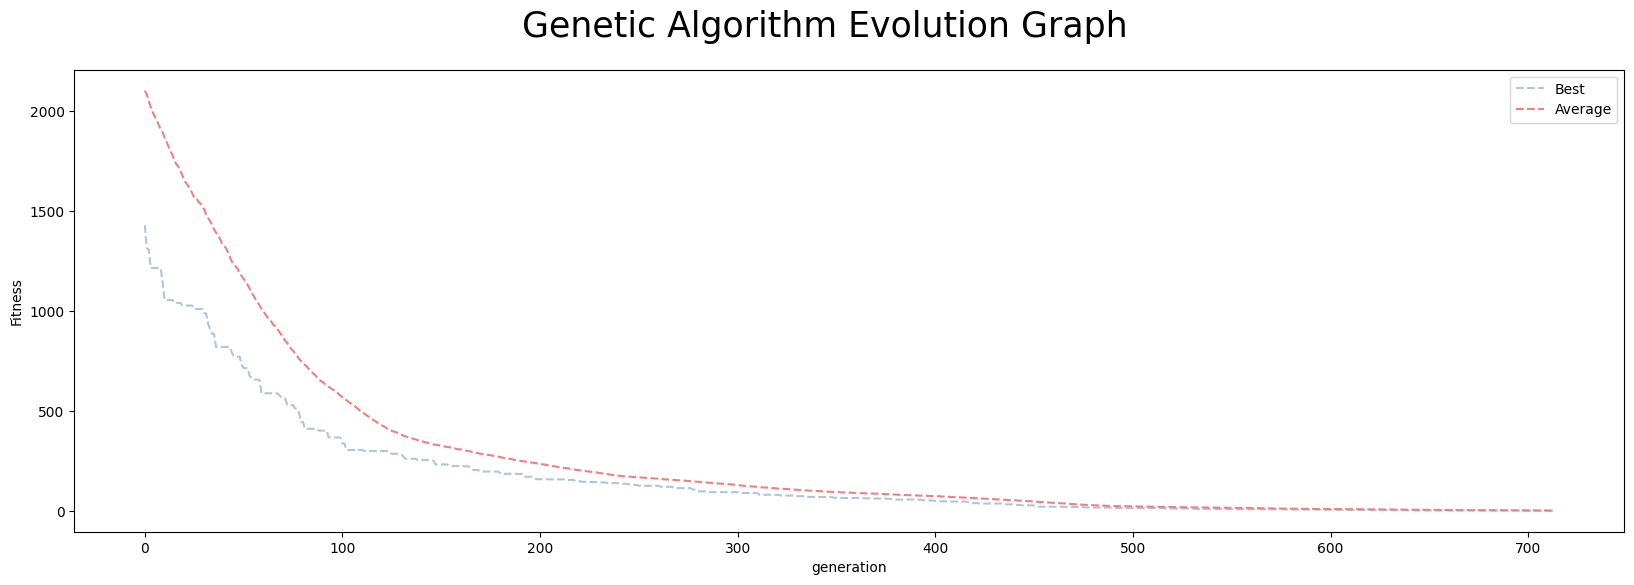

Hey, Jude, don't make it bad

In [ ]:
'''
Definição do problema
'''

goal = """Hey, Jude, don't make it bad"""

def dist(candidate):
    d = 0
    for i,c in enumerate(candidate):
        d+=abs(c-ord(goal[i]))
    
    return d

def repr(candidate):
    return ''.join(map(lambda c:chr(c),candidate))


kwargs = {
    'metric': dist,
    'repr': repr,
    'gene_type':'integer',
    'gene_size':len(goal),
    'gene_upper_limit':255,
    'mutation_range':(-10,10),
    'mutation_type':'random range',
    'crossover_type':"split",
    'cache_size': 1000,
    'cromossome_size':1
}

run(max_gen=10000,pop_size=1000,prole_size=300,mutation_rate=3/100,**kwargs)


## Exemplo combinacional com gene Binario

Loading Initial Population | Current Fitness = 5.47e+19: 100%|██████████| 1000/1000 [00:01<00:00, 800.13it/s]
AVG = 4.92e+02 | BEST = 1.37e+02 | 1*2*7*7*19=1862 |Total Calls  1144 |  5992:  24%|██▍       | 49/200 [00:07<00:22,  6.86it/s]


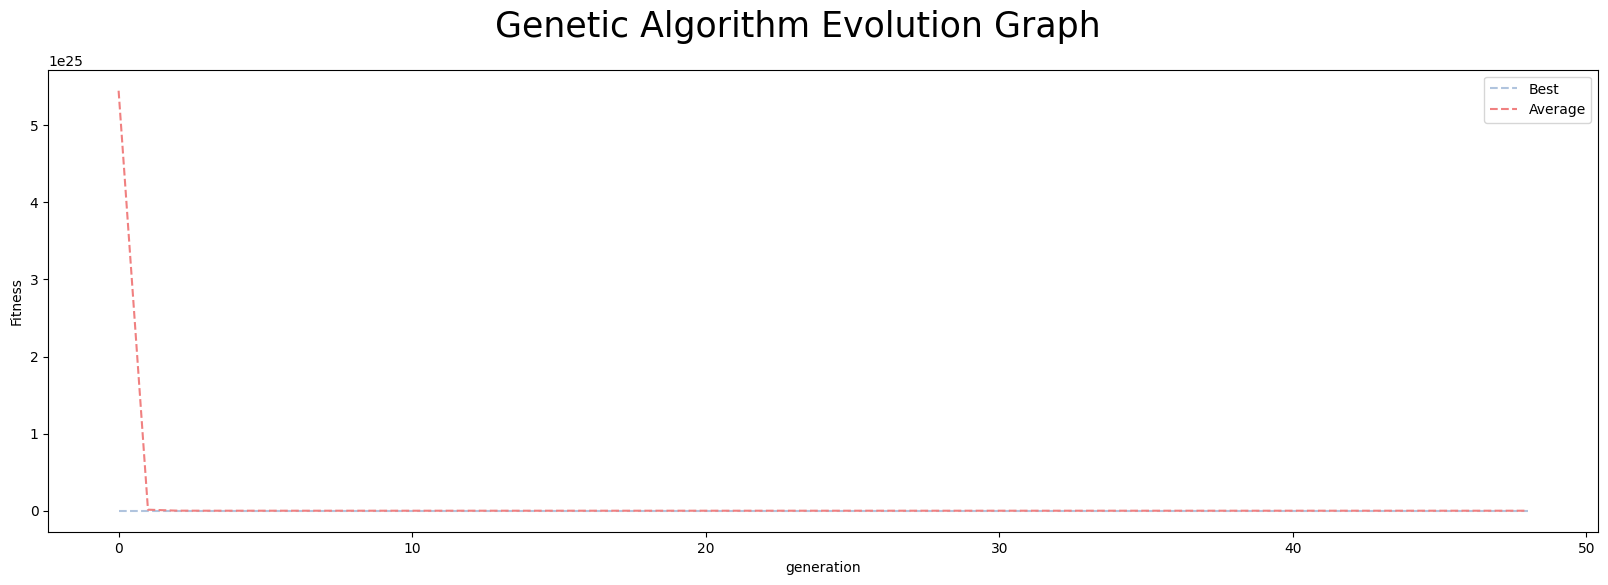

1*7*7*41=2009

In [86]:
'''
Definição do problema
'''

prime_numbers = [1,2,3,5,7,11,13,17,19,23,27,29,31,41,43,47]
target = 1999

'''
gene será uma lista binaria com cada cromossomo representando uma posição na lista
o cromossomo tem tamanho 4
aceitaremos respostas com ate 20 numeros na decomposição
tamanho do gene = 4*20 = 80
'''

def bin2int(candidate):
    r = 0
    for i,c in enumerate(candidate):
        r += (2**i) if c else 0 

    return r

def decode(candidate):

    l_primes = []
    for i in range(20):
        l_primes.append(prime_numbers[bin2int(candidate[i*4:(i+1)*4])])
    
    l_primes = list(filter(lambda x: x!=1, l_primes))

    return l_primes
    


def dist(candidate):
    values = decode(candidate)

    r = 1
    for v in values:
        r*=v

    return abs(r-target)

def repr(candidate):

    l_primes = decode(candidate)
    l_primes.sort()
    r = 1
    str_r = '1'
    for v in l_primes:
        r*=v
        str_r+=f'*{v}'

    return str_r + f'={r}' 


kwargs = {
    'metric':           dist,
    'repr':             repr,
    'gene_type':        'binary',
    'gene_size':        80,
    'mutation_type':    'random range',
    'crossover_type':   "random mix",
    'cache_size':       1000,
    'cromossome_size':  4,
    'init_method':      'mix'
}

run(max_gen=200,pop_size=1000,prole_size=100,mutation_rate=3/100,stop=10,**kwargs)
